In [0]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
import mlflow
import mlflow.statsmodels
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [0]:
spark = SparkSession.builder \
    .appName("CostForecastingARIMA") \
    .getOrCreate()

In [0]:
df = spark.read.csv("dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/cf_arima.csv", header=True, inferSchema=True)


In [0]:
pandas_df = df.toPandas()

In [0]:
pandas_df['LastSaleDate'] = pd.to_datetime(pandas_df['LastSaleDate'])  # Convert LastSaleDate to datetime
df_arima = pandas_df[['LastSaleDate', 'Cost']].rename(columns={'LastSaleDate': 'ds', 'Cost': 'y'})

In [0]:
print(df_arima.isnull().sum())

ds    0
y     0
dtype: int64


In [0]:
train_size = int(len(df_arima) * 0.8)  # 80% for training, 20% for testing
train_df = df_arima[:train_size]
test_df = df_arima[train_size:]

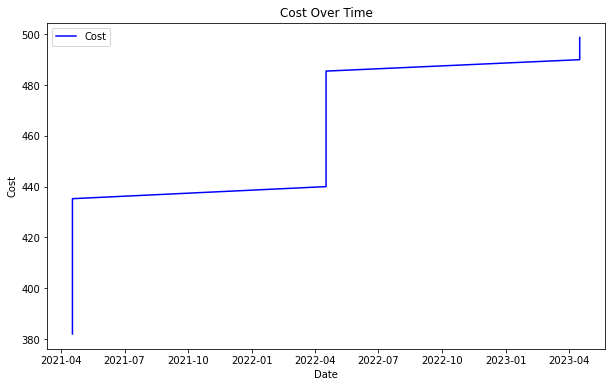

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_arima['ds'], df_arima['y'], label='Cost', color='blue')
plt.title('Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.legend()
plt.show()

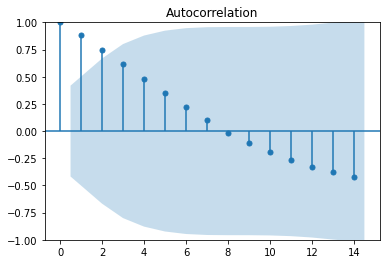

In [0]:
plot_acf(train_df['y'])
plt.show()

In [0]:
import pmdarima as pm

In [0]:
auto_arima_model = pm.auto_arima(train_df['y'], 
                                  seasonal=False, 
                                  stepwise=True, 
                                  trace=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100.091, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=102.035, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102.032, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134.556, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=104.027, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.770 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -48.045
Date:                Mon, 07 Oct 2024   AIC                            100.091
Time:                        17:55:46   BIC                            102.180
Sample:                             0   HQIC                           100.544
                    

In [0]:
predictions = auto_arima_model.predict(n_periods=len(test_df))
predictions_df = pd.DataFrame({'ds': test_df['ds'], 'yhat': predictions})

Mean Absolute Error: 11.173333333333346


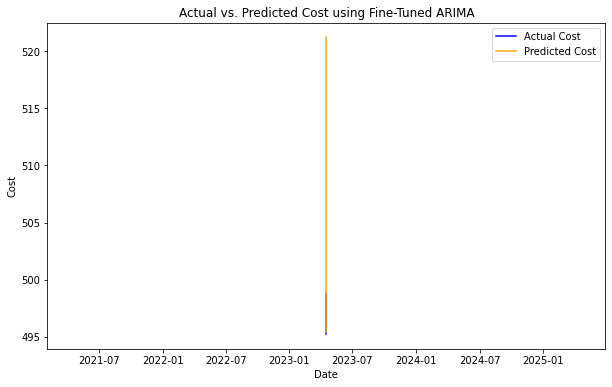

In [0]:
predictions_df['mae'] = abs(test_df['y'] - predictions_df['yhat'])
print(f'Mean Absolute Error: {predictions_df["mae"].mean()}')
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Cost', color='blue')
plt.plot(predictions_df['ds'], predictions_df['yhat'], label='Predicted Cost', color='orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Actual vs. Predicted Cost using Fine-Tuned ARIMA')
plt.show()

In [0]:
import pickle
model_filename = "auto_arima_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(auto_arima_model, file)
with mlflow.start_run():
    mlflow.log_artifact(model_filename) 
    mlflow.log_params({
        "p": auto_arima_model.order[0],
        "d": auto_arima_model.order[1],
        "q": auto_arima_model.order[2]
    })
import os
os.remove(model_filename)


2024/10/07 17:57:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run charming-frog-495 at: https://community.cloud.databricks.com/ml/experiments/4498943658609993/runs/b8d20ff09cc24fc1925d27ed22998be0.
2024/10/07 17:57:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658609993.
